In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from statsmodels.tsa.arima.model import ARIMA

In [55]:
# Charger l'ensemble de données
data = pd.read_parquet('NORWAY_INFLOW_2018-2022.parquet')
data.to_csv('NORWAY_INFLOW_2018-2022.csv')
data = pd.read_csv('NORWAY_INFLOW_2018-2022.csv')
# Remplir les valeurs manquantes avec la moyenne de chaque colonne
data = data.fillna(data.mean())


In [56]:
print(data.columns)

Index(['year', 'week', 'entsoe_inflow', 'time_id', 'H1006', 'H1016', 'H1017',
       'H1030', 'H1041', 'H1043',
       ...
       'H965', 'H969', 'H970', 'H983', 'H984', 'H985', 'H989', 'H99', 'H994',
       'H999'],
      dtype='object', length=475)


In [57]:
# Créer une colonne 'Time_id' pour combiner 'Year' et 'Week' en une seule colonne
# Cela facilite la manipulation des données temporelles dans les étapes ultérieures.
data['time_id'] = data['year'].astype(str) + '-' + data['week'].astype(str)

# Convertir la colonne 'Time_id' en objet datetime
# Cela permet d'utiliser les fonctionnalités de manipulation de date et d'heure de pandas.
data['time_id'] = pd.to_datetime(data['time_id'] + '-1', format='%Y-%W-%w')

# Transformer les variables catégorielles en variables binaires
data = pd.get_dummies(data, columns=["week"])

In [58]:
#Identifiez les colonnes de caractéristiques et la colonne cible:
feature_columns = [col for col in data.columns if col not in ['year', 'week', 'entsoe_inflow', 'time_id']]
target_column = 'entsoe_inflow'
#Créez les ensembles de données X (caractéristiques) et y (cible):
X = data[feature_columns]
y = data[target_column]
# Normaliser les données
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
#Divisez les données en ensembles d'entraînement et de test:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [59]:
# Définir les paramètres à tester
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


# Créer un modèle RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Instancier GridSearchCV avec le modèle RandomForestRegressor et les paramètres à tester
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)



In [60]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, mae, r2


In [61]:
# Entraîner GridSearchCV avec les données d'entraînement
grid_search.fit(X_train, y_train)

# Afficher les meilleurs paramètres trouvés par GridSearchCV
print("Best parameters found: ", grid_search.best_params_)

# Utiliser le meilleur modèle trouvé pour les prédictions et l'évaluation
best_rf = grid_search.best_estimator_

# Instancier les modèles
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest Regressor': best_rf,
    'Support Vector Regressor': SVR()
}

# Entraîner et évaluer les modèles
for model_name, model in models.items():
    model.fit(X_train, y_train)
    mse, mae, r2 = evaluate_model(model, X_test, y_test)

    print(f'{model_name}:')
    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'R-squared (R2): {r2}\n')

#Un R2 (ou coefficient de détermination) de 0,8712158 signifie que le modèle Random Forest que vous avez entraîné est capable d'expliquer 87,12% de la variance des données de test. En d'autres termes, cela indique que le modèle est assez performant pour expliquer une grande partie de la variabilité des données et qu'il est raisonnablement précis pour faire des prédictions.

Fitting 3 folds for each of 144 candidates, totalling 432 fits
Best parameters found:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Linear Regression:
Mean Squared Error (MSE): 3774987427122.449
Mean Absolute Error (MAE): 1358866.86824411
R-squared (R2): 0.17948153034660275

Random Forest Regressor:
Mean Squared Error (MSE): 722070904350.1023
Mean Absolute Error (MAE): 561394.7848367924
R-squared (R2): 0.8430531161079354

Support Vector Regressor:
Mean Squared Error (MSE): 5048297142836.191
Mean Absolute Error (MAE): 1709968.6663286216
R-squared (R2): -0.09728075284029503



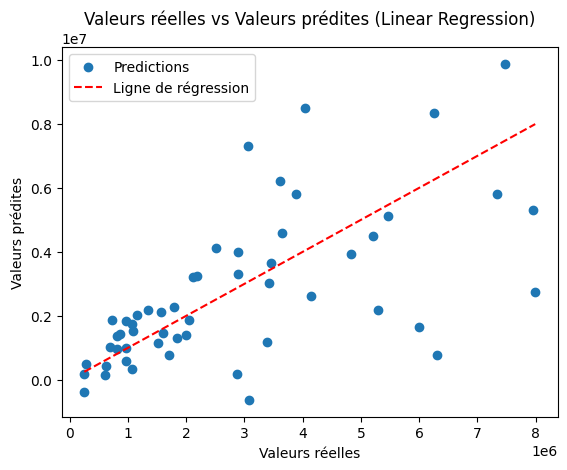

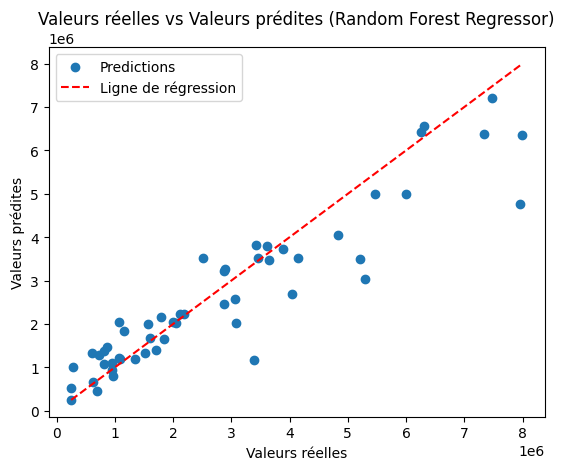

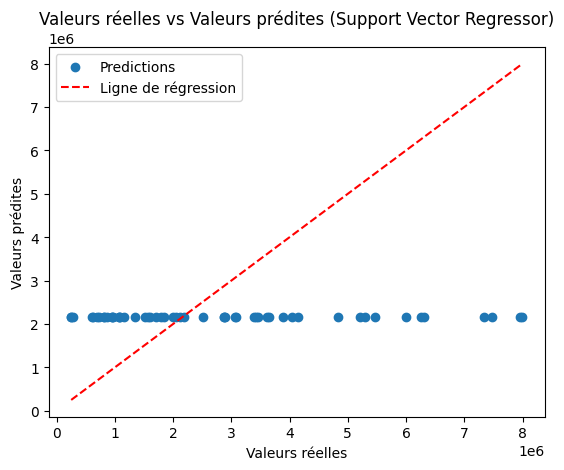

In [62]:
def plot_model_predictions(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)

    plt.scatter(y_test, y_pred, label='Predictions')
    plt.xlabel('Valeurs réelles')
    plt.ylabel('Valeurs prédites')

    regression_line = np.linspace(min(y_test), max(y_test), 100)
    plt.plot(regression_line, regression_line, color='red', linestyle='--', label='Ligne de régression')

    plt.legend()
    plt.title(f'Valeurs réelles vs Valeurs prédites ({model_name})')
    plt.show()
    
    return y_pred

# Visualiser les performances des modèles
for model_name, model in models.items():
    plot_model_predictions(model, X_test, y_test, model_name)

In [63]:
def generate_predictions(model, scaler):
    # Créer un DataFrame pour stocker les prévisions
    predictions = pd.DataFrame(columns=['time_id', 'entsoe_inflow'])

    # Générer les prévisions pour chaque semaine de l'année 2023
    for i in range(1, 53):
        # Créer un DataFrame avec les caractéristiques pour la semaine donnée
        week_data = pd.DataFrame(columns=feature_columns)
        week_data.loc[0] = 0  # Initialiser toutes les caractéristiques à 0
        week_data['year'] = 2023
        week_data['week'] = i
        week_data['time_id'] = pd.to_datetime(f'2023-{i}-1', format='%Y-%W-%w')

        # Normaliser les données
        week_data_scaled = scaler.transform(week_data)

        # Faire la prédiction pour la semaine donnée
        pred = model.predict(week_data_scaled)

        # Ajouter la prédiction au DataFrame des prévisions
        predictions = predictions.append({'time_id': week_data['time_id'][0], 'entsoe_inflow': pred[0]}, ignore_index=True)

    return predictions


In [65]:

# Enregistrer les prédictions dans un fichier CSV
# Enregistrer les prédictions dans un fichier texte
np.savetxt('NORWAY_INFLOW_2023_predictions.txt', y_pred, fmt='%s')



NameError: name 'y_pred' is not defined